In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
#from metpy.calc import relative_humidity_from_dewpoint
#from metpy.units import units
#relative_humidity_from_dewpoint(25 * units.degC, 12 * units.degC).to('percent')


In [5]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200):
    ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] = ds[[f'{driver_variable} at day {n}' for n in range(numdays)]].cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [6]:
def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

In [7]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

In [8]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)

In [9]:
t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(300)] + ['Stations_id', 'Referenzjahr', 'observed time to yellow ripeness']],
                   ds_d2m[[f'd2m at day {day}' for day in range(300)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(300)] + ['Stations_id', 'Referenzjahr']],
                        ds_tp[[f'tp at day {day}' for day in range(300)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])

In [33]:
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = ds_reanalysis #pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to yellow ripeness', 't2m at day 0'])#, 'emergence date'
ds = ds.reset_index()#.drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 't2m', numdays = 200)
day_columns = ['observed time to yellow ripeness']
for column in day_columns:
    ds[column] = pd.to_timedelta(ds[column]).dt.days
ds = ds.where(ds['observed time to yellow ripeness'] > 50).dropna()
    

<Axes: xlabel='observed time to yellow ripeness', ylabel='Count'>

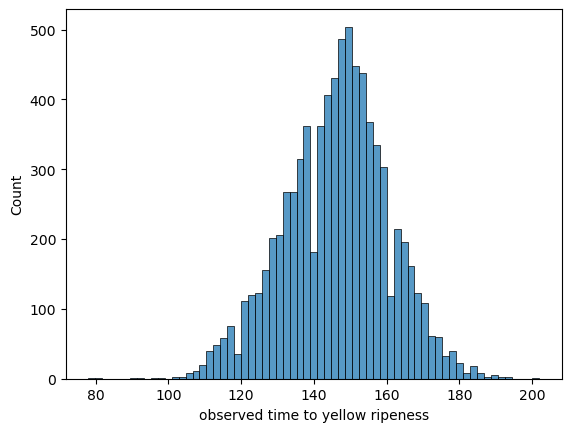

In [34]:
sns.histplot(ds['observed time to yellow ripeness'])

In [35]:
thinning_num = 1
training_columns =  [f't2m at day {thinning_num*n}' for n in range(np.int64(200/thinning_num))]# + [f'ssrd day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #+[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] +  [f'tp day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness'] +[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + ['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile'] #['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile']##+ ['mingrad', 'maxgrad', 'last 75 percentile'] ['mingrad', 'maxgrad', 'last 75 percentile'] #+   ##
response_columns =['observed time to yellow ripeness']# ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
train, test = train_test_split(ds, test_size=0.2)
#clf = GradientBoostingRegressor(
#    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
#    loss='squared_error'
#)
clf = RandomForestRegressor()#max_depth=3, random_state=0, min_samples_leaf=1)
X_training = train[training_columns].values
y_training = train[response_columns].values.ravel()
X_eval = test[training_columns].values
y_eval = test[response_columns].values.ravel()
clf_fit = clf.fit(X_training, y_training)
phase_list = ['yellow ripeness']#['beginning of flowering', 'emergence']#['beginning of flowering', 'yellow ripeness', 'emergence']
for phase_index, phase in enumerate(phase_list):
    train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
    test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
    train[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
    test[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
test['train_test'] = 'test'
train['train_test'] = 'train'
ds_results = pd.concat([test, train], axis=0)
#ds_results['modelled time to emergence'] = ds_results['modelled time to emergence'] + pd.to_datetime(ds_results['WC SOS']).dt.dayofyear
#ds_results['modelled time to emergence']
#ds_results = ds_results.rename(columns = {'observed time emergence to beginning of flowering': 'observed time to beginning of flowering', 
#                                          'observed time emergence to yellow ripeness': 'observed time to yellow ripeness'})
#ds_results['observed time to emergence'] = ds_results['emergence date']
#r2_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['yellow ripeness']) #['emergence', 'beginning of flowering'])#, 'yellow ripeness'

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_4048\1763973681.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_4048\1763973681.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_4048\1763973681.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

R^2 value for model: 0.38075585614650365
Bias: 0.24979091825817035
Variance of modelled values: 102.58508338902931


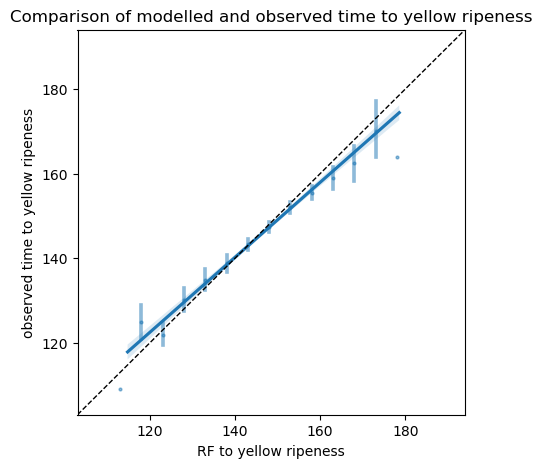

In [38]:
fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
phase = 'yellow ripeness'
comparison_array = test
#x_estimator=np.mean,
minval = min(comparison_array[f'observed time to {phase}'].min(), comparison_array[f'RF to {phase}'].min()) - 1
maxval = max(comparison_array[f'observed time to {phase}'].max(), comparison_array[f'RF to {phase}'].max()) + 1
sns.regplot(x=f'RF to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=axs,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
axs.set_xlim(minval, maxval)
axs.set_ylim(minval, maxval)
axs.set_title(f'Comparison of modelled and observed time to {phase}')
rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'RF to {phase}'])
print(f'R^2 value for model: {rsquared}')
bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'RF to {phase}'].mean()
variance_modelled = comparison_array[f'RF to {phase}'].var()
print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

,index,t2m at day 0,t2m at day 1,t2m at day 2,t2m at day 3,t2m at day 4,t2m at day 5,t2m at day 6,t2m at day 7,t2m at day 8,...,tp at day 293,tp at day 294,tp at day 295,tp at day 296,tp at day 297,tp at day 298,tp at day 299,RF to yellow ripeness,ML check obs to yellow ripeness,train_test
1229,2227,6.821880,15.382727,25.426299,36.361839,47.478628,61.366613,76.360137,92.087730,108.155114,...,0.000537,0.001411,0.007012,0.117262,0.076117,0.206887,0.032320,155.88,150,test
5887,9771,10.362102,22.670924,35.219851,48.720275,58.917214,68.964871,81.618803,96.440089,106.428491,...,0.028252,0.006567,0.001728,0.006910,0.048059,0.032618,0.022429,148.73,143,test
3395,5843,14.212635,27.060617,36.906776,43.261480,54.631452,67.867169,80.398750,93.035048,106.154994,...,0.039242,0.016897,0.026196,0.025135,0.004806,0.006615,0.001474,117.36,104,test
335,588,7.273000,13.175446,24.919370,38.491534,51.266847,61.866687,69.644568,75.646314,83.995341,...,0.000690,0.000280,0.000003,0.000004,0.000052,0.000418,0.001727,142.76,154,test
6996,11448,5.313527,10.112481,19.829432,31.100687,42.341963,52.654766,63.421891,76.381503,90.725280,...,0.006928,0.004264,0.003688,0.006360,0.001374,0.000026,0.000019,130.54,124,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867,4977,9.549218,19.277065,27.768247,36.920672,46.439767,58.413004,68.908737,77.784251,88.477052,...,0.000105,0.000614,0.001241,0.003583,0.010062,0.030993,0.016340,135.34,126,train
717,1293,7.426252,16.957107,23.879862,31.514991,38.382959,46.719414,57.109405,65.922219,75.781720,...,0.001020,0.002255,0.003401,0.000733,0.000270,0.000092,0.000394,161.84,157,train
4328,7306,11.605508,24.475416,38.757446,54.910572,70.422065,84.892204,97.037775,107.395467,118.206257,...,0.003907,0.000429,0.007439,0.001900,0.000014,0.066115,0.116110,138.86,131,train
1301,2411,7.871030,14.436804,19.983981,24.581344,29.496562,36.533055,43.200187,51.428253,61.561563,...,0.019798,0.017885,0.002834,0.000642,0.009674,0.037016,0.006491,159.04,163,train


In [11]:
#ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
#ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')

#day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
#for colname in day_columns:
#    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

In [13]:
ds['year'].unique()

array([2022., 2023., 2008., 2010., 2011., 2016., 2018., 2019., 2020.,
       2004., 2006., 2007., 2002., 2003., 2012., 2014., 2015.])

In [8]:
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24716\1289162695.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [8]:
ds_LSP = ds_LSP.rename(columns = {'Stations_Id': 'Stations_id'})
ds_LSP = get_station_locations(ds_LSP, station_data)
ds = ds_LSP
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

Text(0.5, 1.0, 'bad')

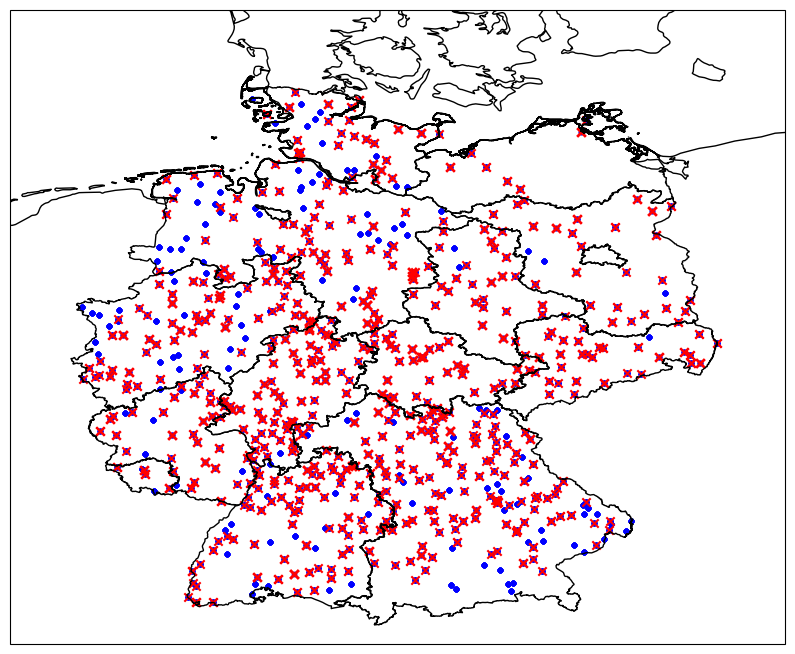

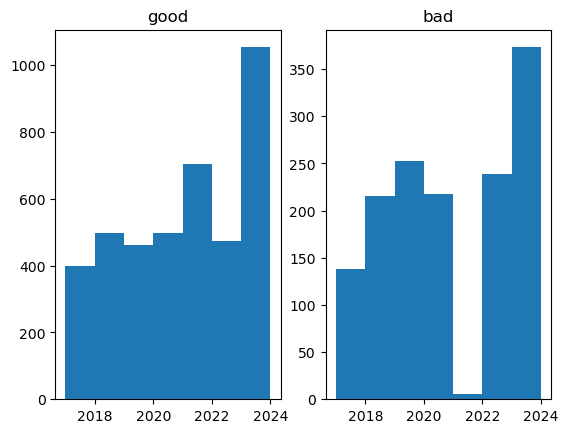

In [25]:
fig, ax = plotting.Germany_plot()
#ds_good_LSP = ds.where(ds['maxday'] > 150)
#ds_good_LSP = ds.where((ds['maxgrad'] < ds['mingrad']))#*(ds['year'] > 2020))
ds_good_LSP = ds.where((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150))# * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270))
#ds_bad_LSP = ds.where(ds['maxday'] < 150)
#ds_bad_LSP = ds.where((ds['maxgrad'] > ds['mingrad']))#*(ds['year'] > 2020))
ds_bad_LSP = ds.where(~((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150)))# * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270)))
ax.scatter(ds_good_LSP['lon'], ds_good_LSP['lat'], c='blue', label='good', s = 10)
ax.scatter(ds_bad_LSP['lon'], ds_bad_LSP['lat'], c='red', label='bad', marker='x')

fig, ax = plt.subplots(1, 2)
ax[0].hist(ds_good_LSP['year'], bins=7)
ax[0].set_title('good')
ax[1].hist(ds_bad_LSP['year'], bins=7)
ax[1].set_title('bad')


In [22]:
def hist2d_proportions(lats, lons, subset_lats, subset_lons, bin_num=20, font_size = 20, title = 'Frequency of observations of ripeness time by location', colorname = 'Proportion of \'good\' observations', vmax = 0.6, save=False):
    hist_full, lonedges, latedges = np.histogram2d(lons, lats, bins=bin_num)#, range=[[0, 4], [0, 4]])
    hist_subset, lonedges, latedges = np.histogram2d(subset_lons, subset_lats, bins=bin_num)
    hist = (hist_subset/hist_full)*(hist_full>10)
    lonpos, latpos = np.meshgrid(lonedges, latedges, indexing="ij")#np.meshgrid(lonedges[:-1] + sizelon, latedges[:-1] + sizelat, indexing="ij")
    lonpos = lonpos#.ravel()
    latpos = latpos#.ravel()
    fig, ax = plotting.Germany_plot(figsize = (10, 10))
    ax.set_title(title, fontsize = font_size)
    densities = ax.pcolormesh(lonpos, latpos, hist, cmap='Purples', vmax = vmax, vmin = 0)
    cbar = plt.colorbar(densities, fraction = 0.03)
    cbar.set_label(label = colorname, size=font_size)
    cbar.ax.tick_params(labelsize=font_size - 2)
    if save:
        fig.savefig(f'plots/bad_obs.png', bbox_inches='tight')

In [27]:
print(len(all_latlon), len(good_latlon))

5531 4090


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_40376\460333463.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


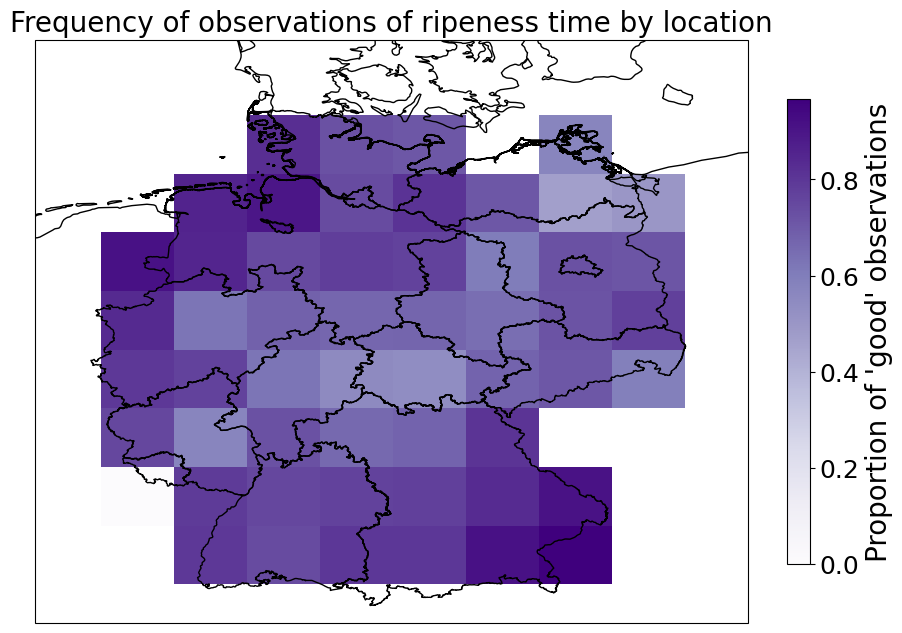

In [28]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
all_latlon = ds[['lat', 'lon']].dropna()
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], good_latlon['lat'], good_latlon['lon'], bin_num = 8, vmax=None)#, vmax = 0.6)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_40376\460333463.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


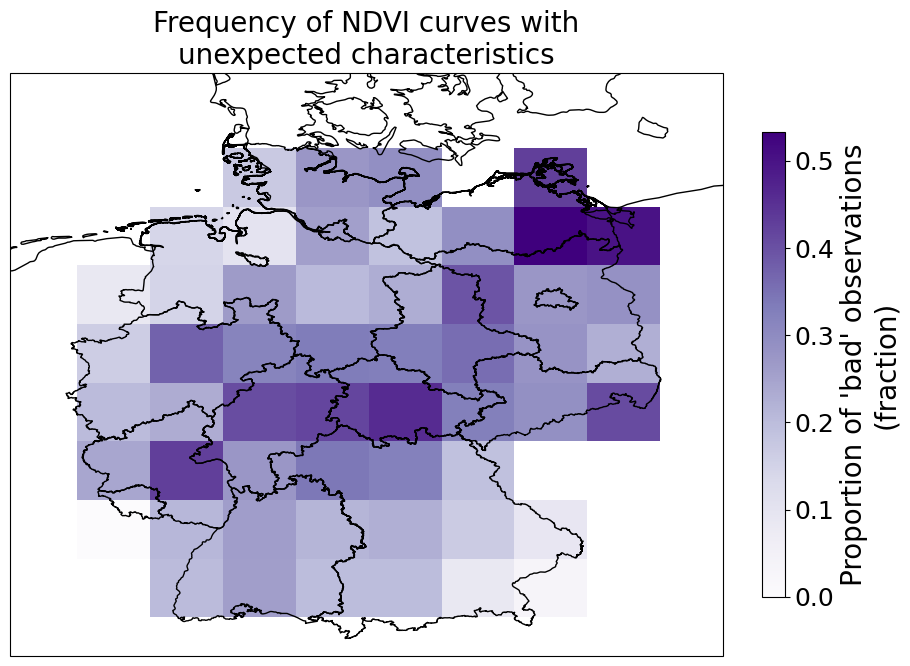

In [31]:
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], bad_latlon['lat'], bad_latlon['lon'], bin_num = 8, vmax = None,
                   title='Frequency of NDVI curves with\nunexpected characteristics',
                   colorname = 'Proportion of \'bad\' observations\n(fraction)', save=True)

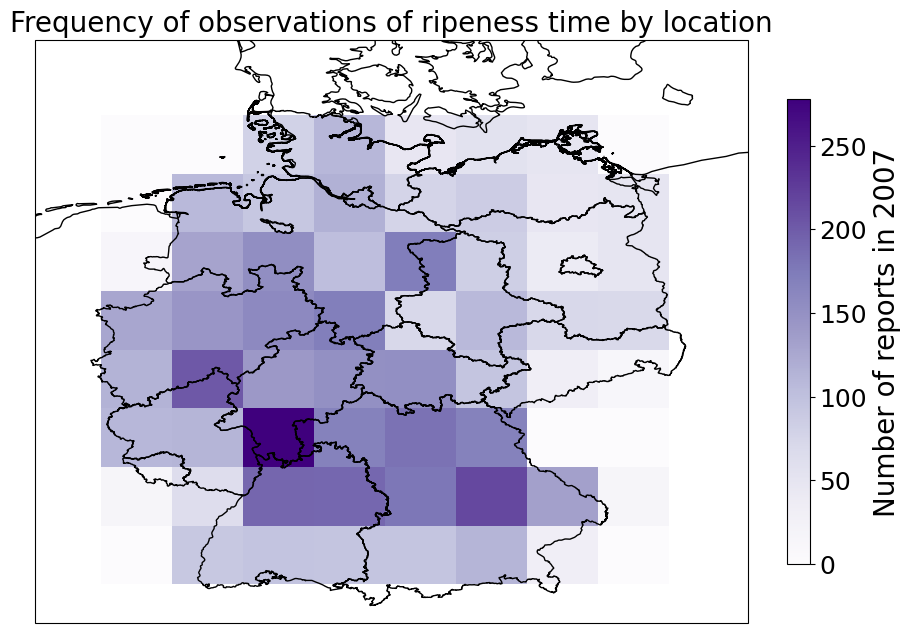

In [42]:
plotting.hist2d_locations(all_latlon['lat'], all_latlon['lon'], bin_num=8)

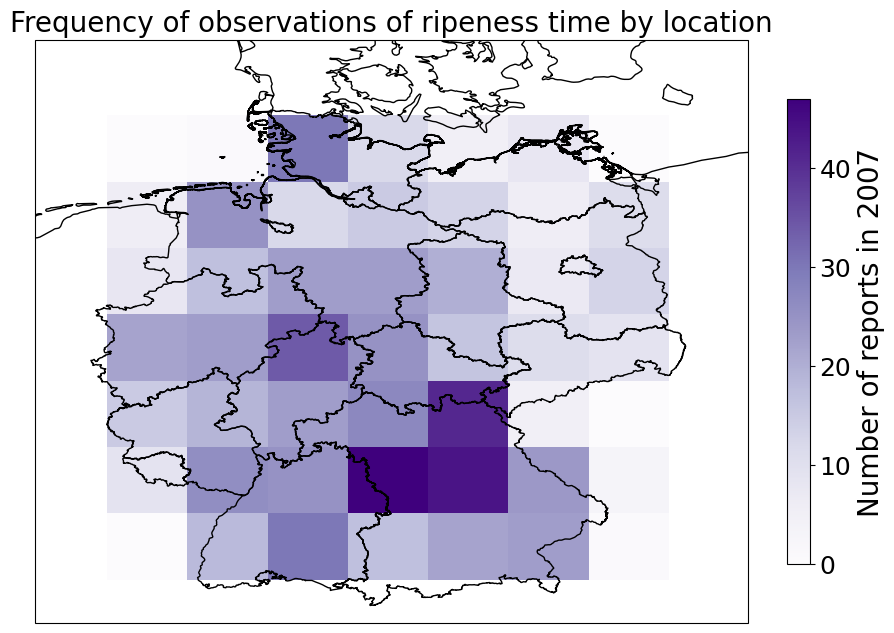

In [17]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(good_latlon['lat'], good_latlon['lon'], bin_num = 7)

In [19]:
len(good_latlon)

814

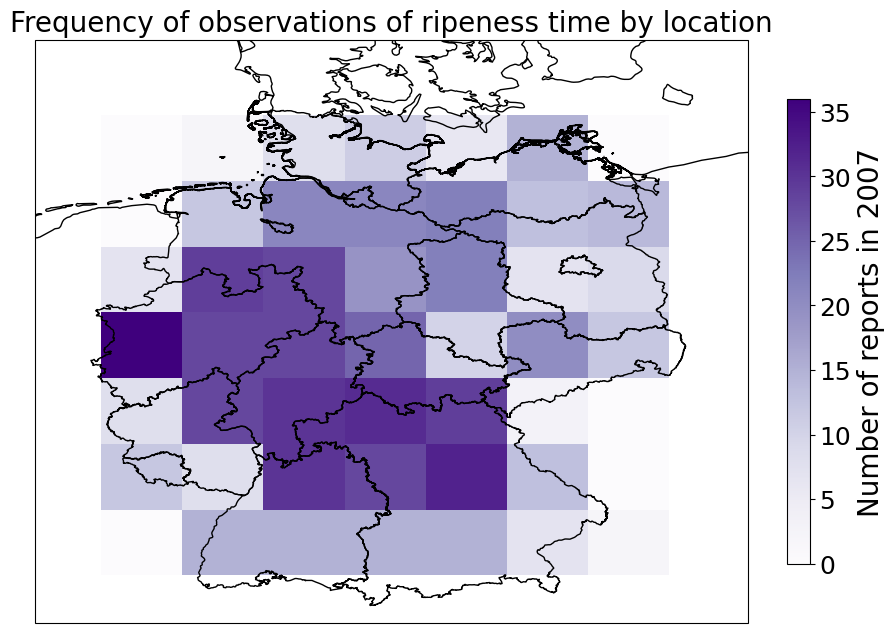

In [20]:
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(bad_latlon['lat'], bad_latlon['lon'], bin_num = 7)

In [82]:
len(ds.where(ds['modelled time to emergence'] < 400)['modelled time to emergence'].dropna())

1112

In [81]:
len(ds)

1673

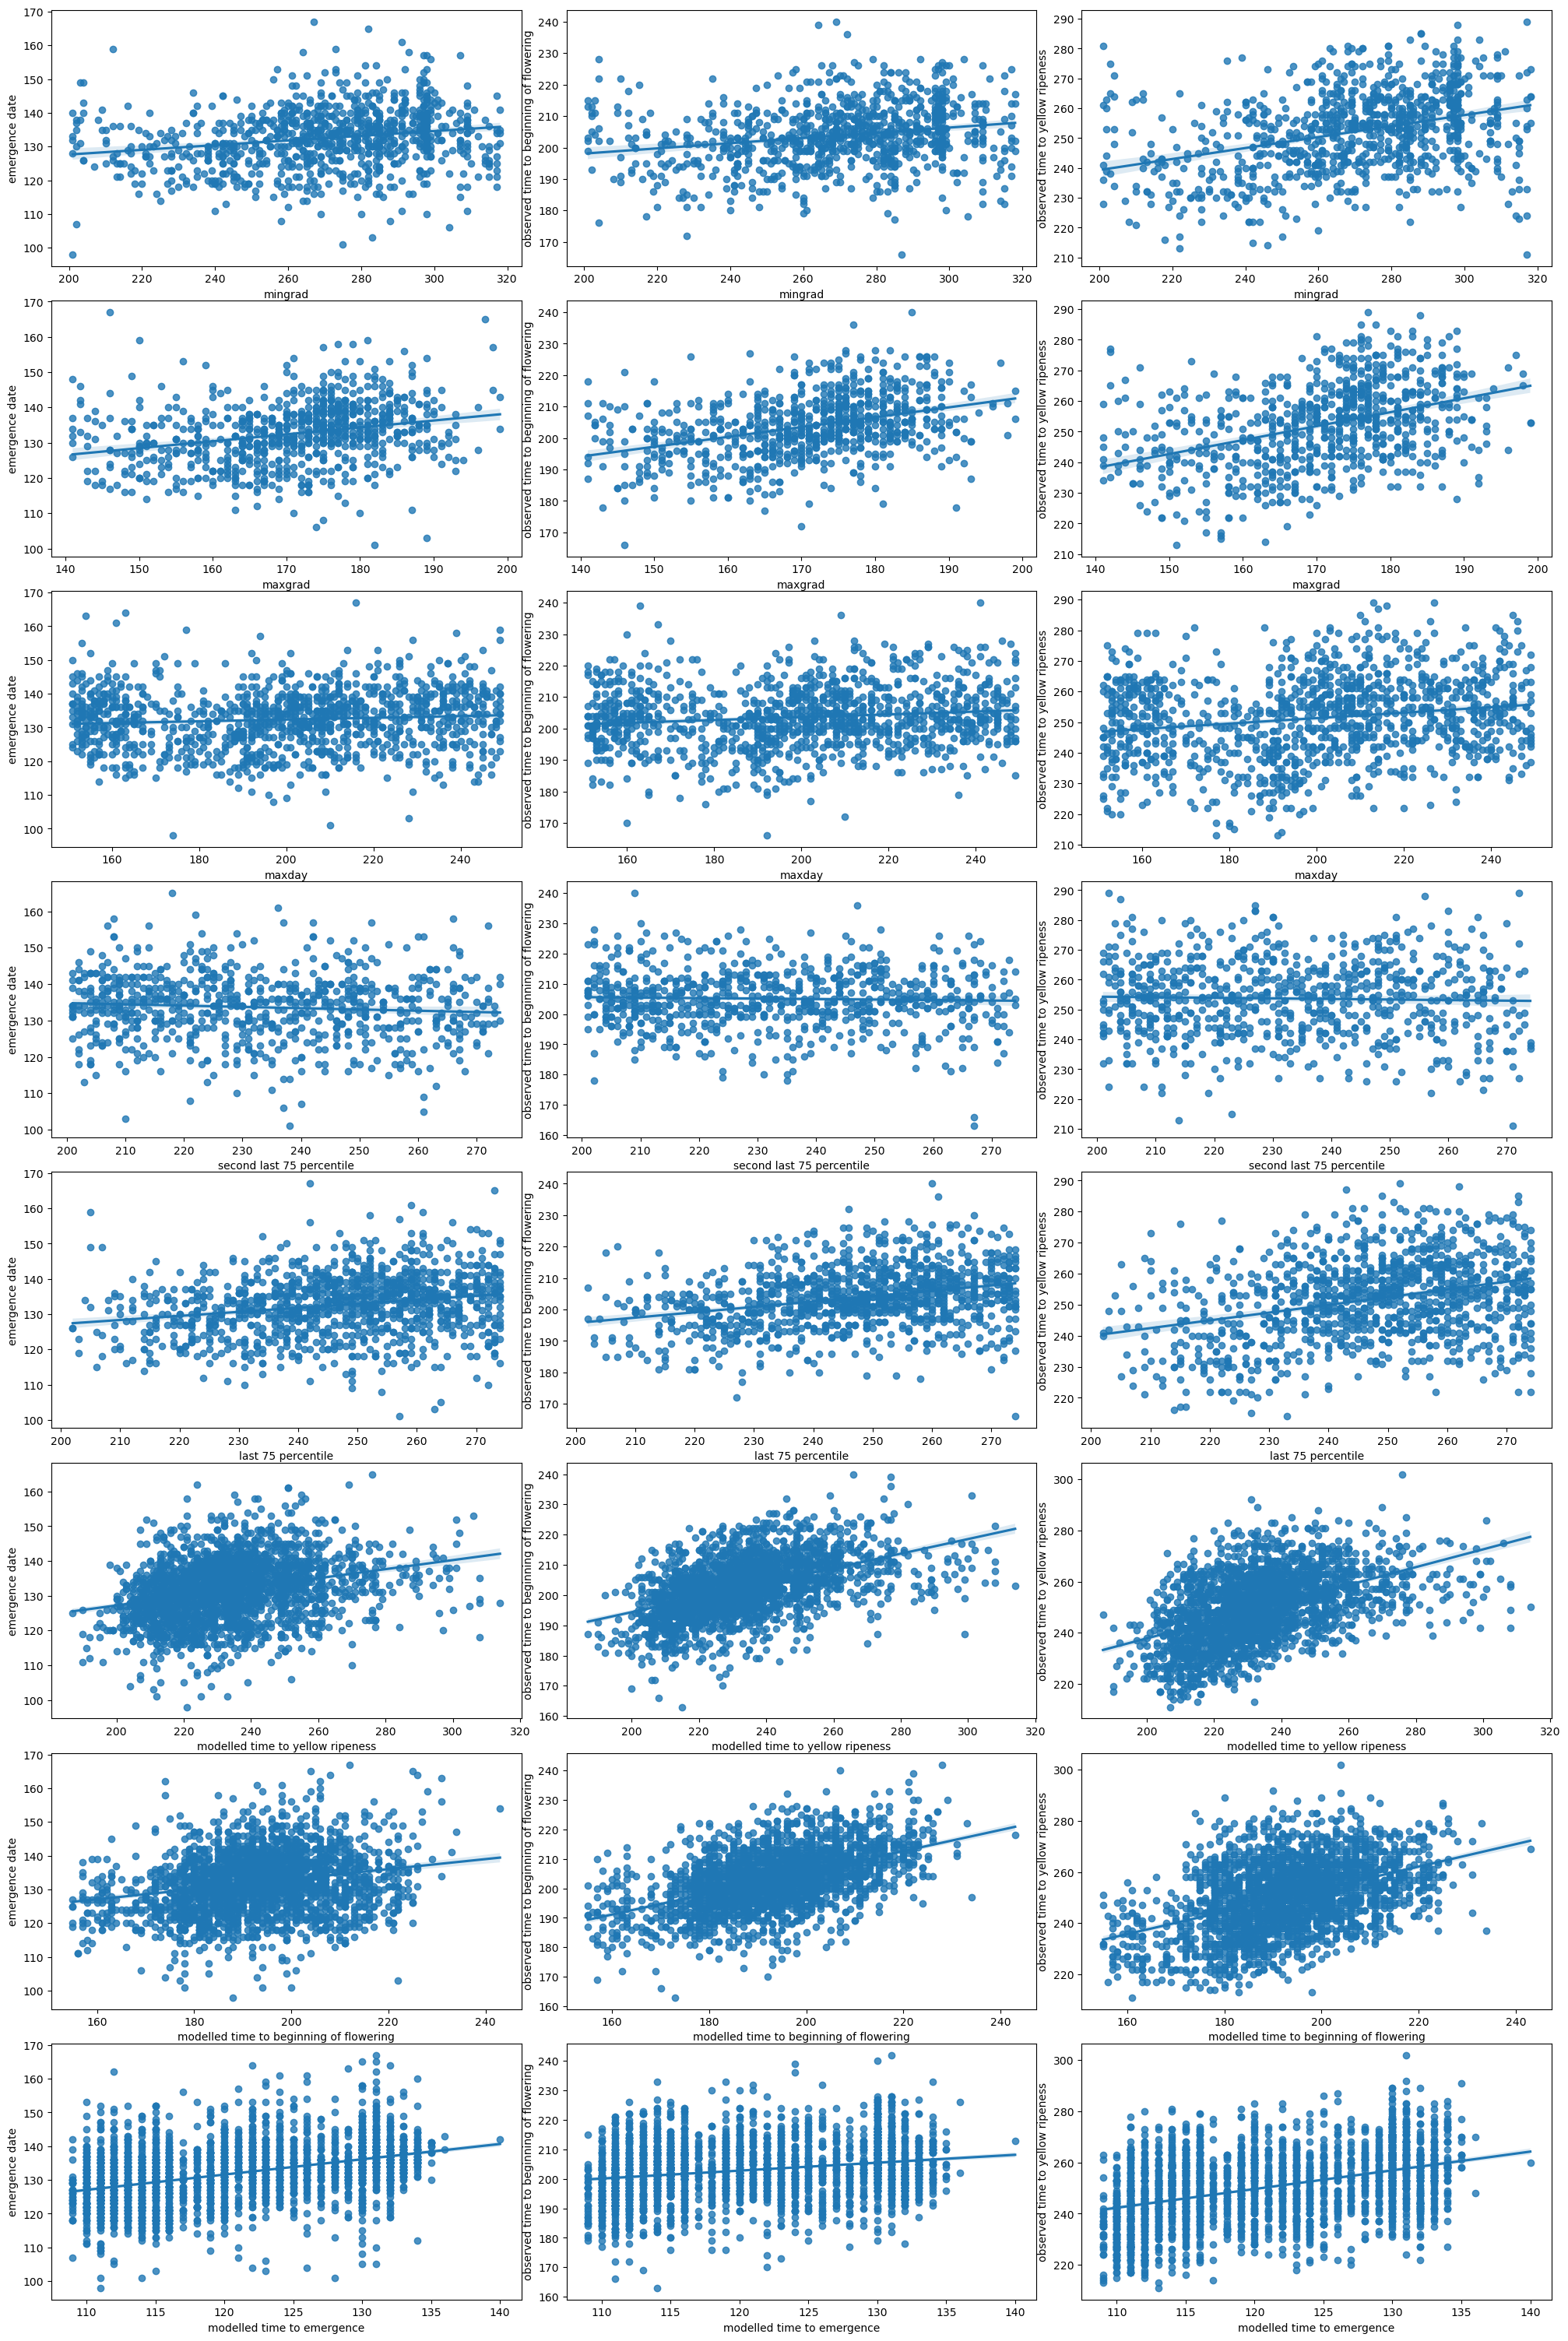

In [9]:
fig, axes = plt.subplots(8, 3, figsize = (20, 30))
fig.tight_layout()
predictors = ['mingrad', 'maxgrad', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'modelled time to yellow ripeness', 'modelled time to beginning of flowering', 'modelled time to emergence']
observed_variables = ['emergence date', 'observed time to beginning of flowering', 'observed time to yellow ripeness']

ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] + ds['emergence date']
ds['observed time to yellow ripeness'] = ds['observed time to yellow ripeness'] + ds['emergence date']
ds['modelled time to emergence'] = ds['modelled time to emergence'] + pd.to_datetime(ds['WC SOS']).dt.dayofyear
ds['modelled time to beginning of flowering'] = ds['modelled time to beginning of flowering'] + ds['modelled time to emergence']
ds['modelled time to yellow ripeness'] = ds['modelled time to yellow ripeness'] + ds['modelled time to emergence']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 365)*(ds[observed_variable] > 0))
for predictor_index, predictor in enumerate(predictors):
    for observed_variable_index, observed_variable in enumerate(observed_variables):
        if predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
            if predictor == 'mingrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] > 200)).dropna(how='all')
            elif predictor == 'maxgrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] < 200)*(ds_no_outliers[predictor] > 140)).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds.where((ds[predictor] < 250)*(ds[predictor] > 150)).dropna(how='all')
        elif predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where((ds[predictor] < 275)*(ds[predictor] > 200)).dropna(how='all')
        elif predictor == 'modelled time to emergence' or predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            ds_no_outliers = ds.where(ds[predictor] < 365).dropna(how='all')
            #if predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            #    ds_no_outliers = ds_no_outliers.where(ds_no_outliers[predictor] > ds_no_outliers['modelled time to emergence'] + 5).dropna(how='all')
        else:
            ds_no_outliers = ds
        

        sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index, observed_variable_index])

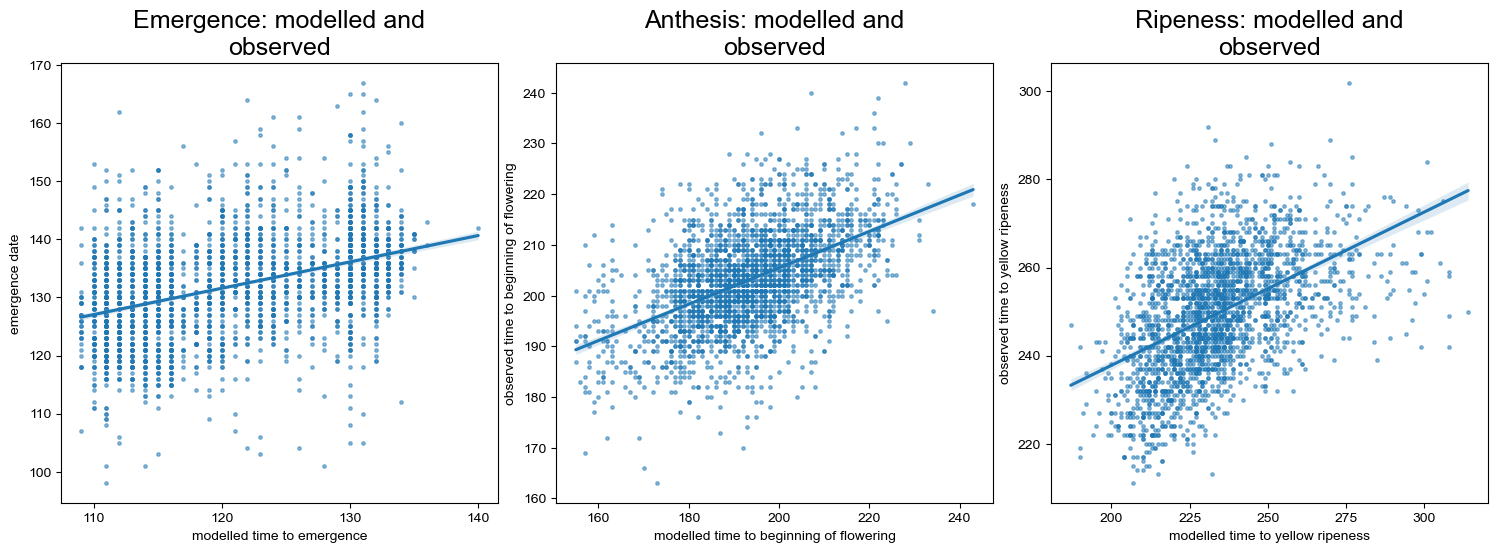

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout()
predictors = ['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness']
observed_variables = ['emergence date', 'observed time to beginning of flowering', 'observed time to yellow ripeness']

ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] + ds['emergence date']
ds['observed time to yellow ripeness'] = ds['observed time to yellow ripeness'] + ds['emergence date']
ds['modelled time to emergence'] = ds['modelled time to emergence'] + pd.to_datetime(ds['WC SOS']).dt.dayofyear
ds['modelled time to beginning of flowering'] = ds['modelled time to beginning of flowering'] + ds['modelled time to emergence']
ds['modelled time to yellow ripeness'] = ds['modelled time to yellow ripeness'] + ds['modelled time to emergence']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 365)*(ds[observed_variable] > 0))
for predictor_index, predictor in enumerate(predictors):
    variable_name = ['Emergence', 'Anthesis', 'Ripeness'][predictor_index]
    observed_variable_index = predictor_index
    observed_variable = observed_variables[observed_variable_index]
    ds_no_outliers = ds.where(ds[predictor] < 365).dropna(how='all')
    sns.set(font_scale=1.5)
    sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index],
                scatter_kws={'alpha':0.5, 's':6})
    axes[predictor_index].set_title(f'{variable_name}: modelled and\nobserved')
fig.savefig('plots/modelled_vs_observed.png', bbox_inches='tight')

In [39]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')
ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_d2m.csv')
ds_d2m = ds_d2m.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ssrd.csv')
ds_ssrd = ds_ssrd.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_tp.csv')
ds_tp = ds_tp.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_reanalysis1 = pd.merge(ds_t2m, ds_d2m, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis2 = pd.merge(ds_ssrd, ds_tp, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis = pd.merge(ds_reanalysis1, ds_reanalysis2, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
print('Should be all the same if it worked: ', len(ds_reanalysis), len(ds_ssrd), len(ds_tp), len(ds_d2m))

Should be all the same if it worked:  4914 4914 4914 4914


In [65]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
#ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to yellow ripeness', 'emergence date', 't2m day 0'])
ds = ds.where(ds['observed time to yellow ripeness'] > 0).dropna(how='all')
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 't2m', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'tp', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'ssrd', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'd2m', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
#ds = ds.where((ds['last 75 percentile'] < 275)*(ds['last 75 percentile'] > 200)).dropna(how='all')
#ds = ds.where(ds['maxgrad'] < ds['mingrad']).dropna(how='all')
thinning_num = 40

In [49]:
ds

,level_0,year,Stations_Id,mingrad,maxgrad,minday,maxday,second last 75 percentile,last 75 percentile,t2m day 0,...,tp day 190,tp day 191,tp day 192,tp day 193,tp day 194,tp day 195,tp day 196,tp day 197,tp day 198,tp day 199
0,0,2018.0,7521.0,103.0,163.0,130.0,191.0,235.0,236.0,8.120025,...,1.079194,1.097430,1.100882,1.102217,1.125145,1.132307,1.133410,1.144167,1.154736,1.162982
1,1,2019.0,7521.0,189.0,313.0,217.0,141.0,104.0,159.0,5.582989,...,2.149894,2.150392,2.150671,2.155572,2.157814,2.163171,2.168591,2.169808,2.169819,2.169821
2,2,2020.0,7521.0,172.0,228.0,207.0,121.0,105.0,150.0,5.267146,...,1.729573,1.736761,1.737511,1.742701,1.762747,1.772651,1.773627,1.793633,1.818072,1.861151
3,3,2021.0,7521.0,297.0,179.0,155.0,231.0,263.0,265.0,4.266895,...,2.423310,2.430643,2.430654,2.431859,2.444890,2.449248,2.449459,2.449459,2.451668,2.460435
4,4,2022.0,7521.0,228.0,188.0,106.0,281.0,222.0,261.0,7.686438,...,1.505837,1.508876,1.522803,1.528690,1.529857,1.529936,1.530059,1.530777,1.535976,1.536664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,6315,2023.0,19700.0,NaN,NaN,NaN,NaN,NaN,NaN,5.713335,...,1.774917,1.789063,1.813220,1.833408,1.838644,1.842771,1.873079,1.880978,1.884756,1.886885
2124,6327,2023.0,19722.0,NaN,NaN,NaN,NaN,NaN,NaN,4.639520,...,2.452768,2.460860,2.461400,2.469852,2.493725,2.497888,2.529235,2.542170,2.550203,2.573253
2125,6328,2018.0,19724.0,NaN,NaN,NaN,NaN,NaN,NaN,12.007923,...,0.670239,0.675225,0.680017,0.683380,0.684747,0.685769,0.685935,0.686724,0.688105,0.688996
2126,6334,2018.0,19727.0,NaN,NaN,NaN,NaN,NaN,NaN,11.099592,...,1.346113,1.348694,1.381384,1.395194,1.401051,1.404730,1.406385,1.412935,1.441650,1.450446


In [74]:
training_columns =  [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'ssrd day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #+[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] +  [f'tp day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness'] +[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + ['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile'] #['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile']##+ ['mingrad', 'maxgrad', 'last 75 percentile'] ['mingrad', 'maxgrad', 'last 75 percentile'] #+   ##
response_columns =['observed time to yellow ripeness']# ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
ds2 = ds.dropna(subset = training_columns + response_columns).reset_index()
training, verification = subsample(ds2, subsample_frac = 0.9)

In [75]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth = 3,
                             min_samples_leaf=2)
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='squared_error'
)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()#max_depth=3, random_state=0, min_samples_leaf=1)
X_training = training[training_columns].values
y_training = training[response_columns].values.ravel()
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values.ravel()
clf_fit = clf.fit(X_training, y_training)
phase_list = ['yellow ripeness']#['beginning of flowering', 'emergence']#['beginning of flowering', 'yellow ripeness', 'emergence']
for phase_index, phase in enumerate(phase_list):
    training.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
    verification.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
    training[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
    verification[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
verification['verification'] = 'verification'
training['verification'] = 'training'
ds_results = pd.concat([verification, training], axis=0)
ds_results['modelled time to emergence'] = ds_results['modelled time to emergence'] + pd.to_datetime(ds_results['WC SOS']).dt.dayofyear
ds_results['modelled time to emergence']
ds_results = ds_results.rename(columns = {'observed time emergence to beginning of flowering': 'observed time to beginning of flowering', 
                                          'observed time emergence to yellow ripeness': 'observed time to yellow ripeness'})
ds_results['observed time to emergence'] = ds_results['emergence date']
r2_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['yellow ripeness']) #['emergence', 'beginning of flowering'])#, 'yellow ripeness'


In [77]:
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values

r = permutation_importance(clf_fit, X_eval, y_eval,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{training_columns[i]:<15}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

d2m day 40      0.308  +/- 0.058
ssrd day 40     0.012  +/- 0.022
d2m day 120     0.002  +/- 0.018
ssrd day 160    0.000  +/- 0.014
ssrd day 80     -0.003  +/- 0.013
d2m day 80      -0.008  +/- 0.010
d2m day 160     -0.012  +/- 0.016
ssrd day 120    -0.017  +/- 0.017
d2m day 0       -0.023  +/- 0.010
ssrd day 0      -0.034  +/- 0.016


In [ ]:
import requests
full_catalog_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images/catalog.json'
full_catalog_info = requests.get(full_catalog_url)
first = True
for location_info in full_catalog_info.json()['links'][2:3]:
    labels = []
    if location_info['rel'] == 'child':
        location_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images' + location_info['href'][1:]
        catalog_info = requests.get(location_url)
        print(catalog_info.json()['id'])
        image_links = catalog_info.json()['links']
        locs = catalog_info.json()['extent']['spatial']['bbox'][0]
        for index, infos in enumerate(image_links):
            #print(index)
            image_info_location = infos['href']
            image_info = requests.get(image_info_location)
            if 'assets' in image_info.json().keys():
                image_label_location = image_info.json()['assets']['label']['href']
                image_label = requests.get(image_label_location).json()
                labels.append(image_label[0])
        dataframe_to_add = pd.DataFrame(labels)
        dataframe_to_add['west'] = locs[0]
        dataframe_to_add['south'] = locs[1]
        dataframe_to_add['east'] = locs[2]
        dataframe_to_add['north'] = locs[3]
        if first:
            phen_data = dataframe_to_add
            first = False
        else:
            phen_data = pd.concat([phen_data, dataframe_to_add])
for index, record in phen_data.iterrows():
    if record['growth_stage'] == 'V':
        filename = record['filename']
        print(filename)
        print(f'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/images/{filename}')
print(phen_data['growth_stage'].unique())